<a href="https://colab.research.google.com/github/PsorTheDoctor/microarray-data/blob/main/generative/microarrays_pixelcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PixelCNN: Generowanie mikromacierzy
##Import bibliotek

In [1]:
!git clone https://github.com/PsorTheDoctor/microarray-data.git
%cd microarray-data/

Cloning into 'microarray-data'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 97 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/microarray-data


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from utils.load_data import load_data_by_label
from augmentation.augmentation import *

##Załadowanie danych

In [27]:
num_classes = 1
input_shape = (20, 50, 1)
n_residual_blocks = 5
# Podział danych na traningowe i testowe
(x1, x2) = load_data_by_label(label=1)
# Zaokrąglenie wszystkich pikseli mniejszych od 33% z 256 do 0
# Wszystko powyżej tej wartości zostanie zaokrąglone do 1, więc wartości
# będą równe 0 lub 1
data = np.concatenate((x1, x2), axis=0)
# data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)

##Stworzenie warstw modelu

In [8]:
class PixelConvLayer(layers.Layer):
  def __init__(self, mask_type, **kwargs):
    super(PixelConvLayer, self).__init__()
    self.mask_type = mask_type
    self.conv = layers.Conv2D(**kwargs)

  def build(self, input_shape):
    self.conv.build(input_shape)
    kernel_shape = self.conv.kernel.get_shape()
    self.mask = np.zeros(shape=kernel_shape)
    self.mask[: kernel_shape[0] // 2, ...] = 1.0
    self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
    if self.mask_type == 'B':
      self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

  def call(self, inputs):
    self.conv.kernel.assign(self.conv.kernel * self.mask)
    return self.conv(inputs)


class ResidualBlock(layers.Layer):
  def __init__(self, filters, **kwargs):
    super(ResidualBlock, self).__init__(kwargs);
    self.conv1 = layers.Conv2D(
        filters=filters, kernel_size=1, activation='relu'
    )
    self.pixel_conv = PixelConvLayer(
        mask_type='B',
        filters = filters // 2,
        kernel_size=3,
        activation='relu',
        padding='same'
    )
    self.conv2 = layers.Conv2D(
        filters=filters, kernel_size=1, activation='relu'
    )

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.pixel_conv(x)
    x = self.conv2(x)
    return layers.add([inputs, x])

##Budowa modelu

In [28]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(
    mask_type='A', filters=128, kernel_size=7, activation='relu', padding='same'
)(inputs)

for _ in range(n_residual_blocks):
  x = ResidualBlock(filters=128)(x)

for _ in range(2):
  x = PixelConvLayer(
      mask_type='B',
      filters=128,
      kernel_size=1,
      strides=1,
      activation='relu',
      padding='valid'
  )(x)

out = layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation='sigmoid', padding='valid'
)(x)

pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss='binary_crossentropy')
pixel_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 50, 1)]       0         
_________________________________________________________________
pixel_conv_layer_8 (PixelCon (None, 20, 50, 128)       6400      
_________________________________________________________________
residual_block_5 (ResidualBl (None, 20, 50, 128)       98624     
_________________________________________________________________
residual_block_6 (ResidualBl (None, 20, 50, 128)       98624     
_________________________________________________________________
residual_block_7 (ResidualBl (None, 20, 50, 128)       98624     
_________________________________________________________________
residual_block_8 (ResidualBl (None, 20, 50, 128)       98624     
_________________________________________________________________
residual_block_9 (ResidualBl (None, 20, 50, 128)       9862

In [ ]:
history = pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=100, validation_split=0.1, verbose=2
)

Text(0, 0.5, 'Strata')

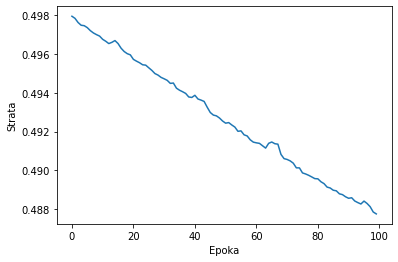

In [39]:
plt.plot(history.history['loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

Text(0, 0.5, 'Strata')

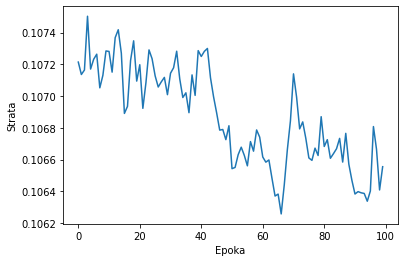

In [38]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

##Demonstracja

In [40]:
from IPython.display import Image, display

batch = 10  # liczba elementów do wygenerowania
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

for row in tqdm(range(rows)):
  for col in range(cols):
    for channel in range(channels):
      
      probs = pixel_cnn.predict(pixels)[:, row, col, channel]
      
      pixels[:, row, col, channel] = tf.math.ceil(
          probs - tf.random.uniform(probs.shape)
      )

# def deprocess_image(x):
#   x = np.stack((x, x, x), 2)

#   x *= 255.0

#   x = np.clip(x, 0, 255).astype('uint8')
#   return x

# for i, pic in enumerate(pixels):
#   keras.preprocessing.image.save_img(
#       'generated_image_{}.png'.format(i), deprocess_image(np.squeeze(pic, -1))
#   )

# display(Image('generated_image_0.png'))
# display(Image('generated_image_1.png'))
# display(Image('generated_image_2.png'))
# display(Image('generated_image_3.png'))

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


In [41]:
print(pixels.shape)

(10, 20, 50, 1)


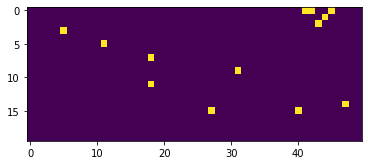

In [42]:
x_aug = pixels[0].reshape((20, 50))
plt.imshow(x_aug, cmap='viridis')